In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [2]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Just rescale for validation and test
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_data = train_datagen.flow_from_directory('Malaria Dataset/train', target_size=(224,224), batch_size=32, class_mode='binary')
valid_data = valid_datagen.flow_from_directory('Malaria Dataset/valid', target_size=(224,224), batch_size=32, class_mode='binary')
test_data = test_datagen.flow_from_directory('Malaria Dataset/test', target_size=(224,224), batch_size=32, class_mode='binary')


Found 13152 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


In [3]:
# Load MobileNetV2 without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base model
base_model.trainable = False

# Add custom head for our binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile it
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
411/411 [==============================] - 501s 1s/step - loss: 0.3802 - accuracy: 0.8349 - val_loss: 0.3157 - val_accuracy: 0.8651
Epoch 2/15
411/411 [==============================] - 460s 1s/step - loss: 0.3209 - accuracy: 0.8687 - val_loss: 0.3357 - val_accuracy: 0.8284
Epoch 3/15
411/411 [==============================] - 424s 1s/step - loss: 0.3061 - accuracy: 0.8732 - val_loss: 0.3340 - val_accuracy: 0.8444
Epoch 4/15
411/411 [==============================] - 474s 1s/step - loss: 0.2948 - accuracy: 0.8802 - val_loss: 0.2837 - val_accuracy: 0.8739
Epoch 5/15
411/411 [==============================] - 533s 1s/step - loss: 0.2889 - accuracy: 0.8837 - val_loss: 0.2735 - val_accuracy: 0.8859
Epoch 6/15
411/411 [==============================] - 560s 1s/step - loss: 0.2803 - accuracy: 0.8879 - val_loss: 0.2845 - val_accuracy: 0.8763
Epoch 7/15
411/411 [==============================] - 673s 2s/step - loss: 0.2886 - accuracy: 0.8825 - val_loss: 0.3175 - val_accuracy: 0.8444

In [5]:
loss, accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {accuracy*100:.2f}%')

20/20 [==============================] - 23s 1s/step - loss: 0.2727 - accuracy: 0.8962
Test Accuracy: 89.62%


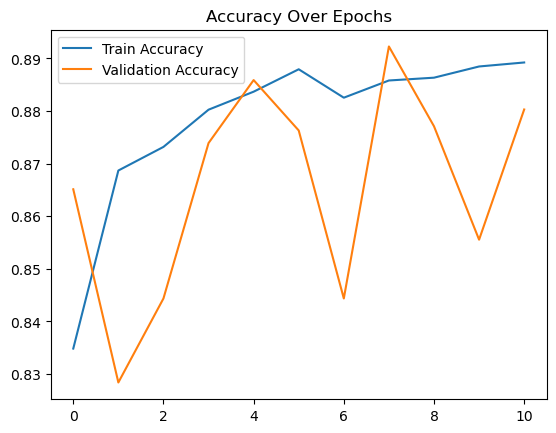

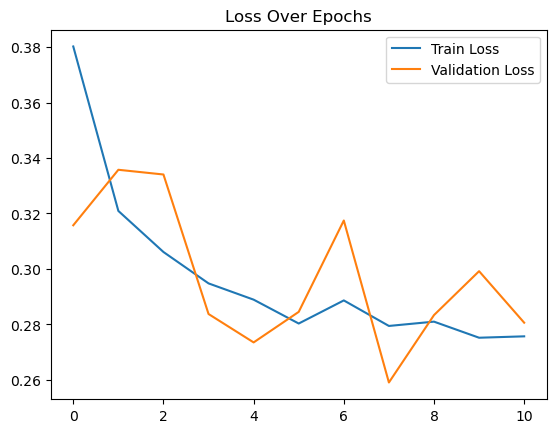

In [6]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


20/20 [==============================] - 23s 942ms/step


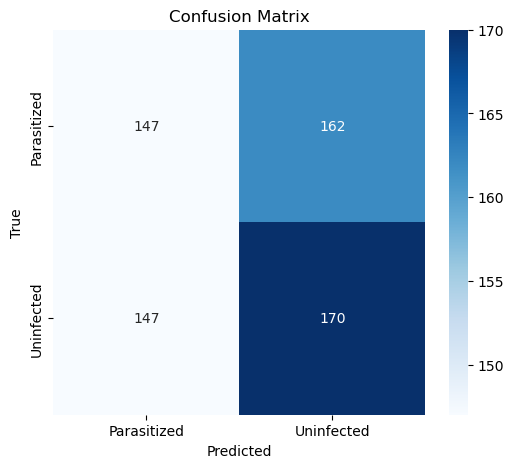

              precision    recall  f1-score   support

 Parasitized       0.50      0.48      0.49       309
  Uninfected       0.51      0.54      0.52       317

    accuracy                           0.51       626
   macro avg       0.51      0.51      0.51       626
weighted avg       0.51      0.51      0.51       626



In [7]:
# Predict
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int).flatten()

# True labels
y_true = test_data.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected']))


1/1 [==============================] - 2s 2s/step


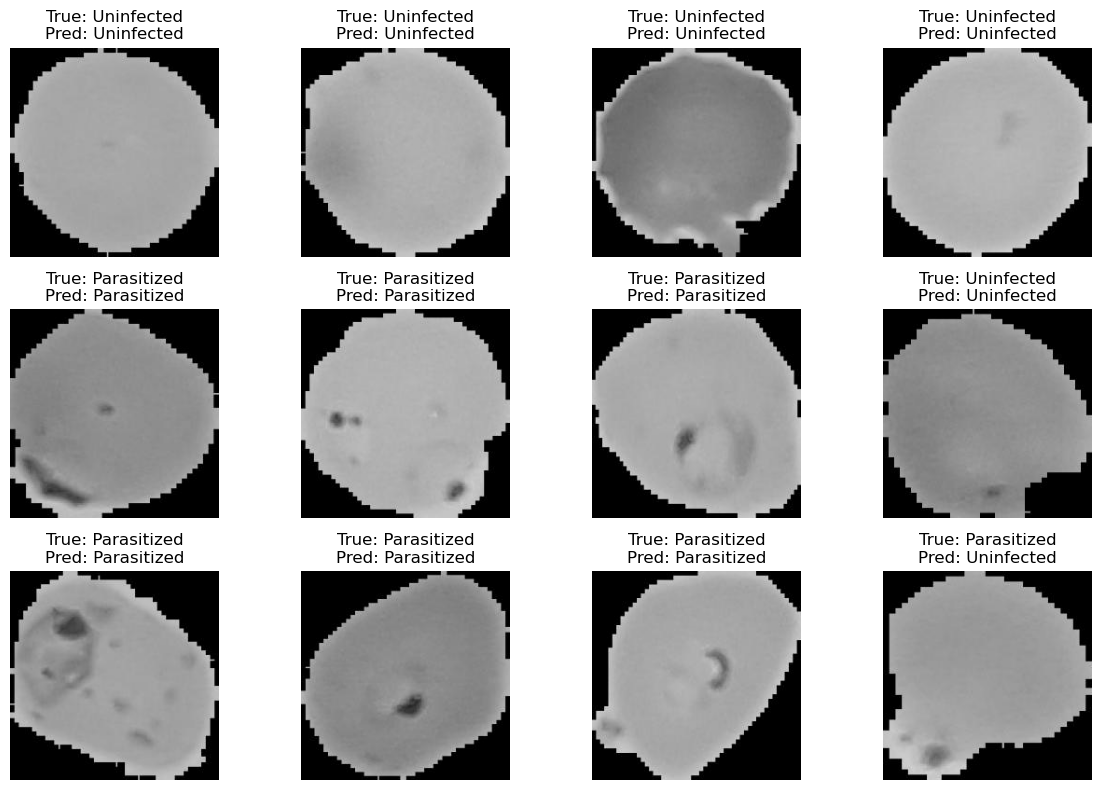

In [8]:
images, labels = next(iter(test_data))

# Predict a batch
predictions = model.predict(images)
predictions = (predictions > 0.5).astype(int).flatten()

# Plot
plt.figure(figsize=(12,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(images[i])
    true_label = 'Parasitized' if labels[i]==0 else 'Uninfected'
    pred_label = 'Parasitized' if predictions[i]==0 else 'Uninfected'
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()
